# Идея

$$F(t) = m \cdot x'' + 2 \cdot m \cdot \delta \cdot x' + w_0^2 \cdot m \cdot x $$

где F(t) — сила(пусть пока известная и константная, например $sin(\Omega t)$.

У такого маятника решение описано [тут](https://mipt.ru/education/chair/physics/S_I/method/Meh_col.pdf) в части 3.3.

Пусть мы знаем фазу и амплитуду реальной системы (формула 31 на стр. 25) и мы хотим настроить параметры $\delta$ и $m$ так чтобы они совпадали для нашей системы и симулятора.

Тогда контроллер принимает следующие вещи: ($\Omega$, $t$, $m$, $\delta$, $w_0$, $x$, $x'$), а выдаёт ($m$, $\delta$), которые бы минимизировали разницу фазы и амплитуды между реальной системой и симулятором.

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, glob, os
import random
import torch
from collections import deque

import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [2]:
from ddpg_agent import Agent

### Env

In [3]:
class PendulumEnv(gym.Env):
    def __init__(self, big_b=1, big_omega=1, theta=0,
                 m=1, k=0.1, beta=0.02, big_f_0=1,
                 n_steps=100, t_min=0, t_max=10):
        """
        Args:
            big_b (float): амплитуда.
            big_omega (float): частота.
            theta (float): фаза.
            m (float): масса грузика.
            k (float): жесткость пружины. 
            beta (float): коэф сопротивления среды.
            big_f_0 (float): ????.
            n_steps (int): количество шагов до завершения среды.
            t_min, t_max (float): min and max time.
        """
        
        # init
        self.initial_params = locals().copy()
        del self.initial_params['self']
        
        # system params
        self.big_b = big_b
        self.big_omega = big_omega
        self.theta = theta
        self.m = m
        self.k = k
        self.beta = beta
        self.big_f_0 = big_f_0
        
        self.delta = self.beta / (2 * self.m)
        self.omega_0 = self.k / self.m
        
        # RL params
        self.n_steps = n_steps
        self.t_min, self.t_max = t_min, t_max
        self._randomize_t()
        self.i = 0
        self.state_space = self._dc_input().shape[0]
        self.observation_space = spaces.Box(low=-10, high=10, shape=(self.state_space,), dtype=np.float32)
        # m, delta, big_omega
        self.action_space = spaces.Box(np.array([0,-2,-.1]), np.array([+10,+2,+.1]), dtype=np.float32)

        
    def _system(self, t=None):
        """Returns the real system position (f.31)."""
        if t is None:
            t = self.t
        return self.big_b * np.cos(self.big_omega * t - self.theta)
    
    def _x(self, t):
        return self._system(t)
    
    def _x_first_deriv(self, t):
        return - self.big_b * self.big_omega * np.sin(self.big_omega * t - self.theta)
    
    def _x_second_deriv(self, t):
        return - self.big_b * (self.big_omega**2) * np.cos(self.big_omega * t - self.theta)
    
    def _system_model(self, m, delta, big_omega, t=None):
        """Returns the model position."""
        if t is None:
            t = self.t
        big_b = self._big_b_model(m, delta, big_omega)
        theta = self._theta_model(m, delta, big_omega)
        return big_b * np.cos(big_omega * t - theta)
    
    def _dc_input(self, t=None):
        if t is None:
            t = self.t
#         return np.array([
# #             self.big_omega,
#             t,
# #             self.m,
# #             self.delta,
#             self.omega_0,
#             self._x(t),
#             self._x_first_deriv(t),
#         ])

        return np.array([
            self.big_omega,
#             t,
            self.m,
            self.delta,
#             self.omega_0,
#             self._x(t),
#             self._x_first_deriv(t),
        ])
    
    def _randomize_t(self):
#         self.t = np.random.uniform(self.t_min, self.t_max)
        t_space = np.arange(10)
        self.t = np.random.choice(t_space)
        
    def _big_b_model(self, m, delta, big_omega):
        omega_0_sqr = self.k / m
        f_0 = self.big_f_0 / m
        
        res = (omega_0_sqr**2 - big_omega**2)**2
        res += 4 * delta**2 * big_omega**2
        res = f_0 / res**0.5
        return res
    
    def _theta_model(self, m, delta, big_omega):
        omega_0_sqr = self.k / m
        
        res = 2 * delta * big_omega
        res /= omega_0_sqr - big_omega**2
        return res

    def step(self, action):

        # state
        self.i += 1

        # reward
        m_, delta_, big_omega_ = tuple(action)
        big_b_ = self._big_b_model(m_, delta_, big_omega_)
        theta_ = self._theta_model(m_, delta_, big_omega_)
        
        reward = 0
        reward -= (self.big_b - big_b_) ** 2
        reward -= (self.theta - theta_) ** 2

        # done
        done = self.i == self.n_steps
        
        # info
        info = {"x_model": big_b_ * np.cos(big_omega_ * self.t - theta_)}
        
        # obs
        self._randomize_t()
        obs = self._dc_input()

        return obs, reward, done, info
    
    def reset(self):
        self.__init__(**self.initial_params)
        self._randomize_t()
        return self._dc_input()
    
    def get_seq_x(self, t_space):
        return [self._x(t) for t in t_space]
    
    def get_seq_states(self, t_space):
        return np.array([self._dc_input(t) for t in t_space])
    
    def render(self):
        pass

#     @property
#     def observation_space(self):
#         return self.observation_space
    
#     @property
#     def action_space(self):
#         
#         return self.action_space

In [4]:
env = PendulumEnv()
o, r, d, _ = env.step([env.m, env.delta, env.big_omega])
# TODO: если поменять, например, на big_b=10 или theta=10, то assert не работает
assert np.isclose(r, 0, atol=1e-3)
o, r, d, _ = env.step([env.m, env.delta, env.big_omega + 1])
assert not np.isclose(r, 0, atol=1e-3)

In [5]:
env.step(np.array([env.m + 10, env.delta, env.big_omega]))

(array([1.  , 1.  , 0.01]),
 -0.8268730489547234,
 False,
 {'x_model': -0.015038029914209177})

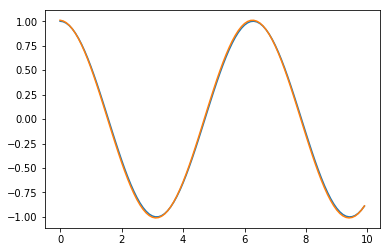

In [6]:
env.reset()
t_space = np.arange(100) / 10
points = [env._system_model(env.m, env.delta, env.big_omega, t) for t in t_space]
# system
plt.plot(t_space, env.get_seq_x(t_space))
# model
plt.plot(t_space, points)
plt.show()

# DDPG

In [7]:
# # TODO: fix actions

# def ddpg(n_episodes=100, max_t=300, print_every=10):
#     scores_deque = deque(maxlen=print_every)
#     scores = []
#     for i_episode in range(1, n_episodes+1):
#         state = env.reset()
# #         agent.reset()
#         score = 0
#         for t in range(max_t):
#             action = agent.act(state, add_noise=False) #TODO: remove
#             print(action)
# #             print(agent.act(state, add_noise=False))
#             next_state, reward, done, _ = env.step(action)
# #             print(reward)
#             agent.step(state, action, reward, next_state, done)
#             state = next_state
#             score += reward
#             if done:
#                 break 
#         scores_deque.append(score)
#         scores.append(score)
#         print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
#         torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
#         torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
#         if i_episode % print_every == 0:
#             print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
#             agent.reset()
#             env.reset()
#             t_space = np.arange(10)#, step=0.1)
#             expected_points = env.get_seq_x(t_space)
#             states = env.get_seq_states(t_space)
#             actions = np.array([agent.act(s, add_noise=False) for s in states])
#             print("states", states)
#             print("action", action)
#             print("actions", actions)
#             points = [env._system_model(a[0], a[1], a[2], t) for a, t in zip(actions, t_space)]
#             plt.plot(t_space, expected_points)
#             plt.plot(t_space, points)
#             plt.show()
            
#     return scores

In [8]:
# env = PendulumEnv()
# agent = Agent(state_size=env.state_space, action_size=3, random_seed=2,
#               min_action_value = env.action_space.low, 
#               max_action_value = env.action_space.high)

In [9]:
# scores = ddpg(n_episodes=100, max_t=300, print_every=1)

In [10]:
# agent.reset()
# env.reset()
# t_space = np.arange(10)#, step=0.1)
# expected_points = env.get_seq_x(t_space)
# states = env.get_seq_states(t_space)
# actions = np.array([agent.act(np.array([env.m, env.delta, env.big_omega]), add_noise=False) for s in states])
# print("states\n", states)
# print("actions\n", actions)
# points = [env._system_model(a[0], a[1], a[2], t) for a, t in zip(actions, t_space)]

# points = [env._system_model(a[0], a[1], a[2], t) for a, t in zip(actions, t_space)]


# plt.plot(t_space, expected_points)
# plt.plot(t_space, points)
# plt.show()

# PPO

In [11]:
from spinup import ppo
import tensorflow as tf
import gym

env_fn = lambda : env


ac_kwargs = dict(hidden_sizes=[30,30], activation=tf.nn.relu, )

logger_kwargs = dict(output_dir='policy', exp_name='exp1')

ppo(env_fn=env_fn, ac_kwargs=ac_kwargs, steps_per_epoch=5000, epochs=250, logger_kwargs=logger_kwargs)

Logging data to policy/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "activation":	"relu",
        "hidden_sizes":	[
            30,
            30
        ]
    },
    "actor_critic":	"mlp_actor_critic",
    "clip_ratio":	0.2,
    "env_fn":	"<function <lambda> at 0x7efe87041d90>",
    "epochs":	250,
    "exp_name":	"exp1",
    "gamma":	0.99,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7efe8706d438>":	{
            "epoch_dict":	{},
            "exp_name":	"exp1",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"policy",
            "output_file":	{
                "<_io.TextIOWrapper name='policy/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_name":	"exp1",
        "output_dir":	"policy"
    },
    "max_ep_len":	1000,
    "pi_lr":	0.0003,
    "sa

---------------------------------------
|             Epoch |               5 |
|      AverageEpRet |       -1.31e+06 |
|          StdEpRet |        7.73e+06 |
|          MaxEpRet |       -1.74e+04 |
|          MinEpRet |       -5.53e+07 |
|             EpLen |             100 |
|      AverageVVals |            -121 |
|          StdVVals |        7.63e-06 |
|          MaxVVals |            -121 |
|          MinVVals |            -121 |
| TotalEnvInteracts |           3e+04 |
|            LossPi |       -1.01e-08 |
|             LossV |        5.19e+12 |
|       DeltaLossPi |        -0.00179 |
|        DeltaLossV |       -5.77e+06 |
|           Entropy |            2.73 |
|                KL |          0.0164 |
|          ClipFrac |           0.264 |
|          StopIter |              13 |
|              Time |            20.3 |
---------------------------------------
---------------------------------------
|             Epoch |               6 |
|      AverageEpRet |       -5.36e+04 |


---------------------------------------
|             Epoch |              15 |
|      AverageEpRet |       -3.75e+05 |
|          StdEpRet |        2.31e+06 |
|          MaxEpRet |       -4.25e+03 |
|          MinEpRet |       -1.65e+07 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |         6.1e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |           8e+04 |
|            LossPi |        8.58e-10 |
|             LossV |        1.21e+12 |
|       DeltaLossPi |        -0.00218 |
|        DeltaLossV |               0 |
|           Entropy |            2.83 |
|                KL |         0.00924 |
|          ClipFrac |            0.14 |
|          StopIter |              79 |
|              Time |            54.4 |
---------------------------------------
---------------------------------------
|             Epoch |              16 |
|      AverageEpRet |       -2.96e+06 |


---------------------------------------
|             Epoch |              24 |
|      AverageEpRet |        -1.8e+04 |
|          StdEpRet |        4.68e+04 |
|          MaxEpRet |            -928 |
|          MinEpRet |       -2.43e+05 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |        1.25e+05 |
|            LossPi |       -3.43e-09 |
|             LossV |        8.32e+08 |
|       DeltaLossPi |        -0.00412 |
|        DeltaLossV |               0 |
|           Entropy |            2.81 |
|                KL |         0.00487 |
|          ClipFrac |          0.0772 |
|          StopIter |              79 |
|              Time |              85 |
---------------------------------------
---------------------------------------
|             Epoch |              25 |
|      AverageEpRet |       -2.49e+04 |


---------------------------------------
|             Epoch |              34 |
|      AverageEpRet |       -2.87e+03 |
|          StdEpRet |        5.09e+03 |
|          MaxEpRet |            -496 |
|          MinEpRet |       -3.29e+04 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |        1.75e+05 |
|            LossPi |       -2.12e-08 |
|             LossV |         1.1e+07 |
|       DeltaLossPi |         -0.0027 |
|        DeltaLossV |               0 |
|           Entropy |            2.73 |
|                KL |          0.0062 |
|          ClipFrac |           0.037 |
|          StopIter |              79 |
|              Time |             120 |
---------------------------------------
---------------------------------------
|             Epoch |              35 |
|      AverageEpRet |        -2.9e+03 |


---------------------------------------
|             Epoch |              43 |
|      AverageEpRet |       -1.23e+03 |
|          StdEpRet |           2e+03 |
|          MaxEpRet |            -272 |
|          MinEpRet |       -1.32e+04 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         2.2e+05 |
|            LossPi |       -4.96e-09 |
|             LossV |        1.29e+06 |
|       DeltaLossPi |        -0.00509 |
|        DeltaLossV |               0 |
|           Entropy |            2.64 |
|                KL |         0.00823 |
|          ClipFrac |           0.065 |
|          StopIter |              79 |
|              Time |             152 |
---------------------------------------
---------------------------------------
|             Epoch |              44 |
|      AverageEpRet |            -786 |


---------------------------------------
|             Epoch |              53 |
|      AverageEpRet |            -279 |
|          StdEpRet |             189 |
|          MaxEpRet |            -183 |
|          MinEpRet |       -1.28e+03 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         2.7e+05 |
|            LossPi |       -6.71e-08 |
|             LossV |        1.79e+05 |
|       DeltaLossPi |        -0.00138 |
|        DeltaLossV |               0 |
|           Entropy |            2.38 |
|                KL |         0.00143 |
|          ClipFrac |          0.0086 |
|          StopIter |              79 |
|              Time |             188 |
---------------------------------------
---------------------------------------
|             Epoch |              54 |
|      AverageEpRet |            -393 |


---------------------------------------
|             Epoch |              63 |
|      AverageEpRet |            -208 |
|          StdEpRet |             135 |
|          MaxEpRet |            -153 |
|          MinEpRet |       -1.09e+03 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         3.2e+05 |
|            LossPi |       -7.55e-08 |
|             LossV |        1.92e+05 |
|       DeltaLossPi |        -0.00161 |
|        DeltaLossV |               0 |
|           Entropy |            2.21 |
|                KL |         0.00218 |
|          ClipFrac |          0.0186 |
|          StopIter |              79 |
|              Time |             224 |
---------------------------------------
---------------------------------------
|             Epoch |              64 |
|      AverageEpRet |            -200 |


---------------------------------------
|             Epoch |              73 |
|      AverageEpRet |            -171 |
|          StdEpRet |            11.1 |
|          MaxEpRet |            -158 |
|          MinEpRet |            -219 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         3.7e+05 |
|            LossPi |        3.43e-08 |
|             LossV |        1.97e+05 |
|       DeltaLossPi |        -0.00187 |
|        DeltaLossV |               0 |
|           Entropy |            2.18 |
|                KL |         0.00159 |
|          ClipFrac |          0.0188 |
|          StopIter |              79 |
|              Time |             260 |
---------------------------------------
---------------------------------------
|             Epoch |              74 |
|      AverageEpRet |            -179 |


---------------------------------------
|             Epoch |              83 |
|      AverageEpRet |            -162 |
|          StdEpRet |            10.8 |
|          MaxEpRet |            -150 |
|          MinEpRet |            -225 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         4.2e+05 |
|            LossPi |               0 |
|             LossV |        2.01e+05 |
|       DeltaLossPi |        -0.00163 |
|        DeltaLossV |               0 |
|           Entropy |            2.03 |
|                KL |         0.00444 |
|          ClipFrac |          0.0208 |
|          StopIter |              79 |
|              Time |             296 |
---------------------------------------
---------------------------------------
|             Epoch |              84 |
|      AverageEpRet |            -161 |


---------------------------------------
|             Epoch |              93 |
|      AverageEpRet |            -158 |
|          StdEpRet |            4.51 |
|          MaxEpRet |            -149 |
|          MinEpRet |            -169 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         4.7e+05 |
|            LossPi |        3.66e-08 |
|             LossV |        2.02e+05 |
|       DeltaLossPi |        -0.00232 |
|        DeltaLossV |               0 |
|           Entropy |            1.86 |
|                KL |         0.00406 |
|          ClipFrac |          0.0254 |
|          StopIter |              79 |
|              Time |             332 |
---------------------------------------
---------------------------------------
|             Epoch |              94 |
|      AverageEpRet |            -156 |


---------------------------------------
|             Epoch |             103 |
|      AverageEpRet |            -153 |
|          StdEpRet |            4.13 |
|          MaxEpRet |            -146 |
|          MinEpRet |            -166 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         5.2e+05 |
|            LossPi |       -3.74e-08 |
|             LossV |        2.04e+05 |
|       DeltaLossPi |        -0.00344 |
|        DeltaLossV |               0 |
|           Entropy |            1.74 |
|                KL |         0.00769 |
|          ClipFrac |          0.0356 |
|          StopIter |              79 |
|              Time |             369 |
---------------------------------------
---------------------------------------
|             Epoch |             104 |
|      AverageEpRet |            -154 |


---------------------------------------
|             Epoch |             113 |
|      AverageEpRet |            -151 |
|          StdEpRet |            14.5 |
|          MaxEpRet |            -142 |
|          MinEpRet |            -249 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         5.7e+05 |
|            LossPi |       -3.74e-08 |
|             LossV |        2.04e+05 |
|       DeltaLossPi |         -0.0012 |
|        DeltaLossV |               0 |
|           Entropy |            1.43 |
|                KL |          0.0011 |
|          ClipFrac |          0.0128 |
|          StopIter |              79 |
|              Time |             405 |
---------------------------------------
---------------------------------------
|             Epoch |             114 |
|      AverageEpRet |            -149 |


---------------------------------------
|             Epoch |             123 |
|      AverageEpRet |            -144 |
|          StdEpRet |            3.25 |
|          MaxEpRet |            -139 |
|          MinEpRet |            -157 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         6.2e+05 |
|            LossPi |       -6.87e-09 |
|             LossV |        2.07e+05 |
|       DeltaLossPi |         -0.0027 |
|        DeltaLossV |               0 |
|           Entropy |            1.19 |
|                KL |         0.00338 |
|          ClipFrac |          0.0262 |
|          StopIter |              79 |
|              Time |             441 |
---------------------------------------
---------------------------------------
|             Epoch |             124 |
|      AverageEpRet |            -143 |


---------------------------------------
|             Epoch |             133 |
|      AverageEpRet |            -139 |
|          StdEpRet |            2.41 |
|          MaxEpRet |            -134 |
|          MinEpRet |            -147 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         6.7e+05 |
|            LossPi |        8.62e-08 |
|             LossV |        2.08e+05 |
|       DeltaLossPi |        -0.00194 |
|        DeltaLossV |               0 |
|           Entropy |           0.968 |
|                KL |         0.00252 |
|          ClipFrac |          0.0204 |
|          StopIter |              79 |
|              Time |             478 |
---------------------------------------
---------------------------------------
|             Epoch |             134 |
|      AverageEpRet |            -139 |


---------------------------------------
|             Epoch |             143 |
|      AverageEpRet |            -135 |
|          StdEpRet |            2.06 |
|          MaxEpRet |            -131 |
|          MinEpRet |            -139 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |        3.05e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         7.2e+05 |
|            LossPi |       -1.53e-09 |
|             LossV |         2.1e+05 |
|       DeltaLossPi |        -0.00367 |
|        DeltaLossV |               0 |
|           Entropy |           0.772 |
|                KL |         0.00741 |
|          ClipFrac |          0.0418 |
|          StopIter |              79 |
|              Time |             515 |
---------------------------------------
---------------------------------------
|             Epoch |             144 |
|      AverageEpRet |            -135 |


---------------------------------------
|             Epoch |             153 |
|      AverageEpRet |            -133 |
|          StdEpRet |            1.55 |
|          MaxEpRet |            -130 |
|          MinEpRet |            -137 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |               0 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         7.7e+05 |
|            LossPi |         6.1e-09 |
|             LossV |        2.11e+05 |
|       DeltaLossPi |        -0.00106 |
|        DeltaLossV |           -2.05 |
|           Entropy |           0.698 |
|                KL |         0.00223 |
|          ClipFrac |          0.0102 |
|          StopIter |              79 |
|              Time |             551 |
---------------------------------------
---------------------------------------
|             Epoch |             154 |
|      AverageEpRet |            -133 |


---------------------------------------
|             Epoch |             163 |
|      AverageEpRet |            -133 |
|          StdEpRet |             1.5 |
|          MaxEpRet |            -129 |
|          MinEpRet |            -136 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |               0 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         8.2e+05 |
|            LossPi |         6.1e-09 |
|             LossV |         2.1e+05 |
|       DeltaLossPi |       -0.000968 |
|        DeltaLossV |           -2.19 |
|           Entropy |           0.612 |
|                KL |         0.00179 |
|          ClipFrac |          0.0108 |
|          StopIter |              79 |
|              Time |             588 |
---------------------------------------
---------------------------------------
|             Epoch |             164 |
|      AverageEpRet |            -134 |


---------------------------------------
|             Epoch |             173 |
|      AverageEpRet |            -134 |
|          StdEpRet |            1.96 |
|          MaxEpRet |            -131 |
|          MinEpRet |            -139 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |               0 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         8.7e+05 |
|            LossPi |        4.88e-08 |
|             LossV |         2.1e+05 |
|       DeltaLossPi |        -0.00119 |
|        DeltaLossV |           -10.4 |
|           Entropy |           0.438 |
|                KL |         0.00464 |
|          ClipFrac |          0.0196 |
|          StopIter |              79 |
|              Time |             624 |
---------------------------------------
---------------------------------------
|             Epoch |             174 |
|      AverageEpRet |            -135 |


---------------------------------------
|             Epoch |             183 |
|      AverageEpRet |            -133 |
|          StdEpRet |            1.53 |
|          MaxEpRet |            -130 |
|          MinEpRet |            -137 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |               0 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         9.2e+05 |
|            LossPi |       -5.04e-08 |
|             LossV |         2.1e+05 |
|       DeltaLossPi |        -0.00295 |
|        DeltaLossV |           -12.6 |
|           Entropy |           0.125 |
|                KL |         0.00268 |
|          ClipFrac |          0.0348 |
|          StopIter |              79 |
|              Time |             660 |
---------------------------------------
---------------------------------------
|             Epoch |             184 |
|      AverageEpRet |            -133 |


---------------------------------------
|             Epoch |             193 |
|      AverageEpRet |            -132 |
|          StdEpRet |            1.81 |
|          MaxEpRet |            -129 |
|          MinEpRet |            -137 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |               0 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |         9.7e+05 |
|            LossPi |        1.11e-07 |
|             LossV |         2.1e+05 |
|       DeltaLossPi |         -0.0031 |
|        DeltaLossV |           -14.8 |
|           Entropy |          0.0823 |
|                KL |         0.00696 |
|          ClipFrac |          0.0386 |
|          StopIter |              79 |
|              Time |             697 |
---------------------------------------
---------------------------------------
|             Epoch |             194 |
|      AverageEpRet |            -132 |


---------------------------------------
|             Epoch |             203 |
|      AverageEpRet |            -133 |
|          StdEpRet |             1.5 |
|          MaxEpRet |            -131 |
|          MinEpRet |            -138 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |         6.1e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |        1.02e+06 |
|            LossPi |        1.42e-07 |
|             LossV |         2.1e+05 |
|       DeltaLossPi |        -0.00152 |
|        DeltaLossV |           -25.1 |
|           Entropy |          0.0431 |
|                KL |         0.00283 |
|          ClipFrac |          0.0208 |
|          StopIter |              79 |
|              Time |             733 |
---------------------------------------
---------------------------------------
|             Epoch |             204 |
|      AverageEpRet |            -134 |


---------------------------------------
|             Epoch |             213 |
|      AverageEpRet |            -131 |
|          StdEpRet |            1.65 |
|          MaxEpRet |            -127 |
|          MinEpRet |            -135 |
|             EpLen |             100 |
|      AverageVVals |            -508 |
|          StdVVals |         6.1e-05 |
|          MaxVVals |            -508 |
|          MinVVals |            -508 |
| TotalEnvInteracts |        1.07e+06 |
|            LossPi |        9.61e-08 |
|             LossV |         2.1e+05 |
|       DeltaLossPi |        -0.00131 |
|        DeltaLossV |           -37.8 |
|           Entropy |          -0.177 |
|                KL |         0.00382 |
|          ClipFrac |          0.0188 |
|          StopIter |              79 |
|              Time |             769 |
---------------------------------------
---------------------------------------
|             Epoch |             214 |
|      AverageEpRet |            -131 |


---------------------------------------
|             Epoch |             223 |
|      AverageEpRet |            -129 |
|          StdEpRet |            1.26 |
|          MaxEpRet |            -126 |
|          MinEpRet |            -131 |
|             EpLen |             100 |
|      AverageVVals |            -507 |
|          StdVVals |         6.1e-05 |
|          MaxVVals |            -507 |
|          MinVVals |            -507 |
| TotalEnvInteracts |        1.12e+06 |
|            LossPi |       -6.26e-08 |
|             LossV |        2.11e+05 |
|       DeltaLossPi |        -0.00314 |
|        DeltaLossV |           -54.7 |
|           Entropy |          -0.409 |
|                KL |         0.00578 |
|          ClipFrac |           0.051 |
|          StopIter |              79 |
|              Time |             805 |
---------------------------------------
---------------------------------------
|             Epoch |             224 |
|      AverageEpRet |            -128 |


---------------------------------------
|             Epoch |             233 |
|      AverageEpRet |            -126 |
|          StdEpRet |           0.976 |
|          MaxEpRet |            -124 |
|          MinEpRet |            -128 |
|             EpLen |             100 |
|      AverageVVals |            -506 |
|          StdVVals |               0 |
|          MaxVVals |            -506 |
|          MinVVals |            -506 |
| TotalEnvInteracts |        1.17e+06 |
|            LossPi |       -1.37e-08 |
|             LossV |        2.11e+05 |
|       DeltaLossPi |        -0.00218 |
|        DeltaLossV |           -84.9 |
|           Entropy |          -0.461 |
|                KL |         0.00361 |
|          ClipFrac |          0.0264 |
|          StopIter |              79 |
|              Time |             842 |
---------------------------------------
---------------------------------------
|             Epoch |             234 |
|      AverageEpRet |            -126 |


---------------------------------------
|             Epoch |             243 |
|      AverageEpRet |            -125 |
|          StdEpRet |           0.836 |
|          MaxEpRet |            -123 |
|          MinEpRet |            -127 |
|             EpLen |             100 |
|      AverageVVals |            -505 |
|          StdVVals |               0 |
|          MaxVVals |            -505 |
|          MinVVals |            -505 |
| TotalEnvInteracts |        1.22e+06 |
|            LossPi |        7.78e-08 |
|             LossV |         2.1e+05 |
|       DeltaLossPi |        -0.00164 |
|        DeltaLossV |            -124 |
|           Entropy |          -0.565 |
|                KL |         0.00257 |
|          ClipFrac |           0.019 |
|          StopIter |              79 |
|              Time |             878 |
---------------------------------------
---------------------------------------
|             Epoch |             244 |
|      AverageEpRet |            -125 |


In [12]:
from spinup.utils.test_policy import load_policy, run_policy
_, get_action = load_policy('policy/')
run_policy(env, get_action, render=False)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from policy/simple_save/variables/variables
Using default action op.
Logging data to /tmp/experiments/1559096121/progress.txt
Episode 0 	 EpRet -126.644 	 EpLen 100
Episode 1 	 EpRet -125.338 	 EpLen 100
Episode 2 	 EpRet -124.616 	 EpLen 100
Episode 3 	 EpRet -125.371 	 EpLen 100
Episode 4 	 EpRet -124.676 	 EpLen 100
Episode 5 	 EpRet -125.737 	 EpLen 100
Episode 6 	 EpRet -124.048 	 EpLen 100
Episode 7 	 EpRet -124.251 	 EpLen 100
Episode 8 	 EpRet -125.336 	 EpLen 100
Episode 9 	 EpRet -125.753 	 EpLen 100
Episode 10 	 EpRet -125.051 	 EpLen 100
Episode 11 	 EpRet -125.259 	 EpLen 100
Episode 12 	 EpRet -124.481 	 E

states
 [[1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]
 [1.   1.   0.01]]
actions
 [[-1.7388868  -0.539305    2.7484858 ]
 [-1.9003408  -0.15600926  2.715742  ]
 [-1.9071281  -0.02436808  2.6542284 ]
 [-2.1312292  -0.3386335   2.5005884 ]
 [-1.8249819  -0.11378443  2.5748959 ]
 [-1.7294319  -0.15210052  2.7131183 ]
 [-1.5775373  -0.20686913  2.5385416 ]
 [-1.753413   -0.4815932   2.7359407 ]
 [-1.9854823   0.00543815  2.704327  ]
 [-2.1868258  -0.38040385  2.5592363 ]]


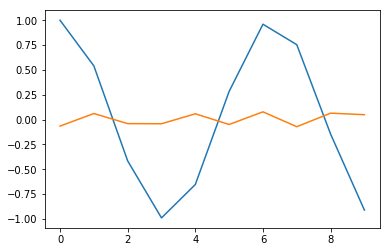

In [13]:
env.reset()
t_space = np.arange(10)#, step=0.1)
expected_points = env.get_seq_x(t_space)
states = env.get_seq_states(t_space)
actions = np.array([get_action(np.array([env.m, env.delta, env.big_omega])) for s in states])
print("states\n", states)
print("actions\n", actions)
points = [env._system_model(a[0], a[1], a[2], t) for a, t in zip(actions, t_space)]



plt.plot(t_space, expected_points)
plt.plot(t_space, points)
plt.show()